In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math

import warnings
warnings.filterwarnings('ignore')

## Loading the data path

In [2]:
with open(r"E:\Learning\TEAI Cup\Data\Parquet Data\latest_data.json", 'r') as f:
    latest_data = json.load(f)
    d1_path = latest_data['d1']
    d2_path = latest_data['d2']
    d3_path = latest_data['d3']

## Loading the actual data using data paths

In [3]:
d1 = pd.read_parquet(d1_path)
d2 = pd.read_parquet(d2_path)
d3 = pd.read_parquet(d3_path)

# Lets try matching all 3 datas using Timestamp, Machine Id

In [52]:
sample = d1.sample()
machine_id = sample.machine_id.values[0]
start_time = pd.to_datetime(sample.machine_event_start_timestamp.values[0]) - pd.Timedelta(minutes=1)
actual_start = pd.to_datetime(sample.machine_event_start_timestamp.values[0])
end_time = pd.to_datetime(sample.machine_event_start_end_timestamp.values[0]) + pd.Timedelta(minutes=1)
actual_end = pd.to_datetime(sample.machine_event_start_end_timestamp.values[0])
part_number = sample.part_number.values[0]
tool_number = sample.tool_number.values[0]

print(f"Machine ID: {machine_id} \nStart Time: {start_time} \nEnd Time: {end_time} \nPart Number: {part_number} \nTool Number: {tool_number}")

Machine ID: S-268 
Start Time: 2025-12-08 02:47:28 
End Time: 2025-12-08 02:51:07 
Part Number: 2-1703930-2 
Tool Number: S1829661


In [53]:
small_d2 = d2[(d2.timestamp >= start_time) & (d2.timestamp <= end_time) & (d2.machine_id == machine_id)]
small_d2

,machine_id,variable_name,value,timestamp,lowerLimit,upperLimit,nominalValue,min,max,average,range,outside_range_count,max_deviation
811181,S-268,spur1Gap,"0.188,0.184,0.185,0.188,0.187,0.186,0.184,0.18...",2025-12-08 02:47:32,-0.034,0.03,0.19,0.179,0.193,0.18520,0.014,100.0,0.011
811182,S-268,spur2DeformationFeder,"44.094,45.038,46.197,46.723,48.948,47.532,44.0...",2025-12-08 02:47:32,-25.000,25.00,50.00,39.792,50.121,45.63416,10.329,100.0,10.208
811183,S-268,spur2Gap,"0.181,0.181,0.181,0.176,0.18,0.179,0.188,0.178...",2025-12-08 02:47:32,-0.034,0.03,0.19,0.166,0.191,0.17842,0.025,100.0,0.024
811184,S-268,spur2Iso,"1.926,1.923,1.922,1.925,1.923,1.925,1.925,1.92...",2025-12-08 02:47:32,-0.100,0.10,1.90,1.919,1.930,1.92404,0.011,100.0,0.030
811185,S-268,spur2Wire,"1.715,1.715,1.715,1.714,1.714,1.715,1.716,1.71...",2025-12-08 02:47:32,-0.100,0.10,1.70,1.711,1.717,1.71437,0.006,100.0,0.017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
811862,S-268,spur1Gap,"0.187,0.186,0.184,0.186,0.19,0.184,0.192,0.184...",2025-12-08 02:51:07,-0.034,0.03,0.19,0.179,0.194,0.18577,0.015,100.0,0.011
811863,S-268,spur1Iso,"1.941,1.941,1.941,1.941,1.94,1.941,1.94,1.942,...",2025-12-08 02:51:07,-0.100,0.10,1.90,1.937,1.942,1.94000,0.005,100.0,0.042
811864,S-268,spur1Wire,"1.729,1.73,1.73,1.73,1.726,1.728,1.727,1.727,1...",2025-12-08 02:51:07,-0.100,0.10,1.70,1.724,1.732,1.72686,0.008,100.0,0.032
811865,S-268,spur1IKastenHinten,"0.986,0.984,0.982,0.984,0.992,0.99,0.985,0.986...",2025-12-08 02:51:07,0.000,0.11,0.95,0.976,0.993,0.98461,0.017,100.0,0.043


In [54]:
# Lets check if there is errors in this and present in the final dataset d3
small_d3 = d3[(d3.timestamp >= actual_start) & (d3.timestamp <= actual_end) & (d3.machine_id == machine_id) & (d3.part_number == part_number)]
small_d3

,machine_id,machine_status_active_code,timestamp,part_number,error_variable,curr,ltl,utl
2870,S-268,200,2025-12-08 02:49:55,2-1703930-2,spur2Gap,0.144,0.156,0.22


# Analysis Based on
#### Min, Max, Mean, Std, range(max -min), % of values outside limit, count of outside values, max deviation from nominal

In [55]:
def add_defect_detection_columns(row:pd.Series ):
    value_list = np.array(list(map(float, row.value.split(","))))
    
    min_val = np.min(value_list)
    max_val = np.max(value_list)
    mean = np.mean(value_list)
    range_val = max_val - min_val
    std = np.std(value_list)
    
    upperLimit, lowerLimit, nominal = row.upperLimit, row.lowerLimit, row.nominalValue
    
    count_outside_values = np.sum((value_list > (upperLimit + nominal)) | (value_list < (nominal + lowerLimit)))
    max_deviation_from_nominal = np.max(np.abs(value_list - nominal))    
    
    return pd.Series({
        "min":min_val,
        "max":max_val,
        "avergae": mean,
        "std": std,
        "range": range_val,
        "outside_range_count": count_outside_values,
        "max_deviation": max_deviation_from_nominal 
    })

In [56]:
small_d2[["min", "max", "average","std", "range", "outside_range_count", "max_deviation"]] = (
    small_d2.apply(add_defect_detection_columns, axis=1)
)
small_d2


,machine_id,variable_name,value,timestamp,lowerLimit,upperLimit,nominalValue,min,max,average,range,outside_range_count,max_deviation,std
811181,S-268,spur1Gap,"0.188,0.184,0.185,0.188,0.187,0.186,0.184,0.18...",2025-12-08 02:47:32,-0.034,0.03,0.19,0.179,0.193,0.18520,0.014,0.0,0.011,0.002800
811182,S-268,spur2DeformationFeder,"44.094,45.038,46.197,46.723,48.948,47.532,44.0...",2025-12-08 02:47:32,-25.000,25.00,50.00,39.792,50.121,45.63416,10.329,0.0,10.208,1.800819
811183,S-268,spur2Gap,"0.181,0.181,0.181,0.176,0.18,0.179,0.188,0.178...",2025-12-08 02:47:32,-0.034,0.03,0.19,0.166,0.191,0.17842,0.025,0.0,0.024,0.005597
811184,S-268,spur2Iso,"1.926,1.923,1.922,1.925,1.923,1.925,1.925,1.92...",2025-12-08 02:47:32,-0.100,0.10,1.90,1.919,1.930,1.92404,0.011,0.0,0.030,0.002486
811185,S-268,spur2Wire,"1.715,1.715,1.715,1.714,1.714,1.715,1.716,1.71...",2025-12-08 02:47:32,-0.100,0.10,1.70,1.711,1.717,1.71437,0.006,0.0,0.017,0.001254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811862,S-268,spur1Gap,"0.187,0.186,0.184,0.186,0.19,0.184,0.192,0.184...",2025-12-08 02:51:07,-0.034,0.03,0.19,0.179,0.194,0.18577,0.015,0.0,0.011,0.003091
811863,S-268,spur1Iso,"1.941,1.941,1.941,1.941,1.94,1.941,1.94,1.942,...",2025-12-08 02:51:07,-0.100,0.10,1.90,1.937,1.942,1.94000,0.005,0.0,0.042,0.001208
811864,S-268,spur1Wire,"1.729,1.73,1.73,1.73,1.726,1.728,1.727,1.727,1...",2025-12-08 02:51:07,-0.100,0.10,1.70,1.724,1.732,1.72686,0.008,0.0,0.032,0.001581
811865,S-268,spur1IKastenHinten,"0.986,0.984,0.982,0.984,0.992,0.99,0.985,0.986...",2025-12-08 02:51:07,0.000,0.11,0.95,0.976,0.993,0.98461,0.017,0.0,0.043,0.003535


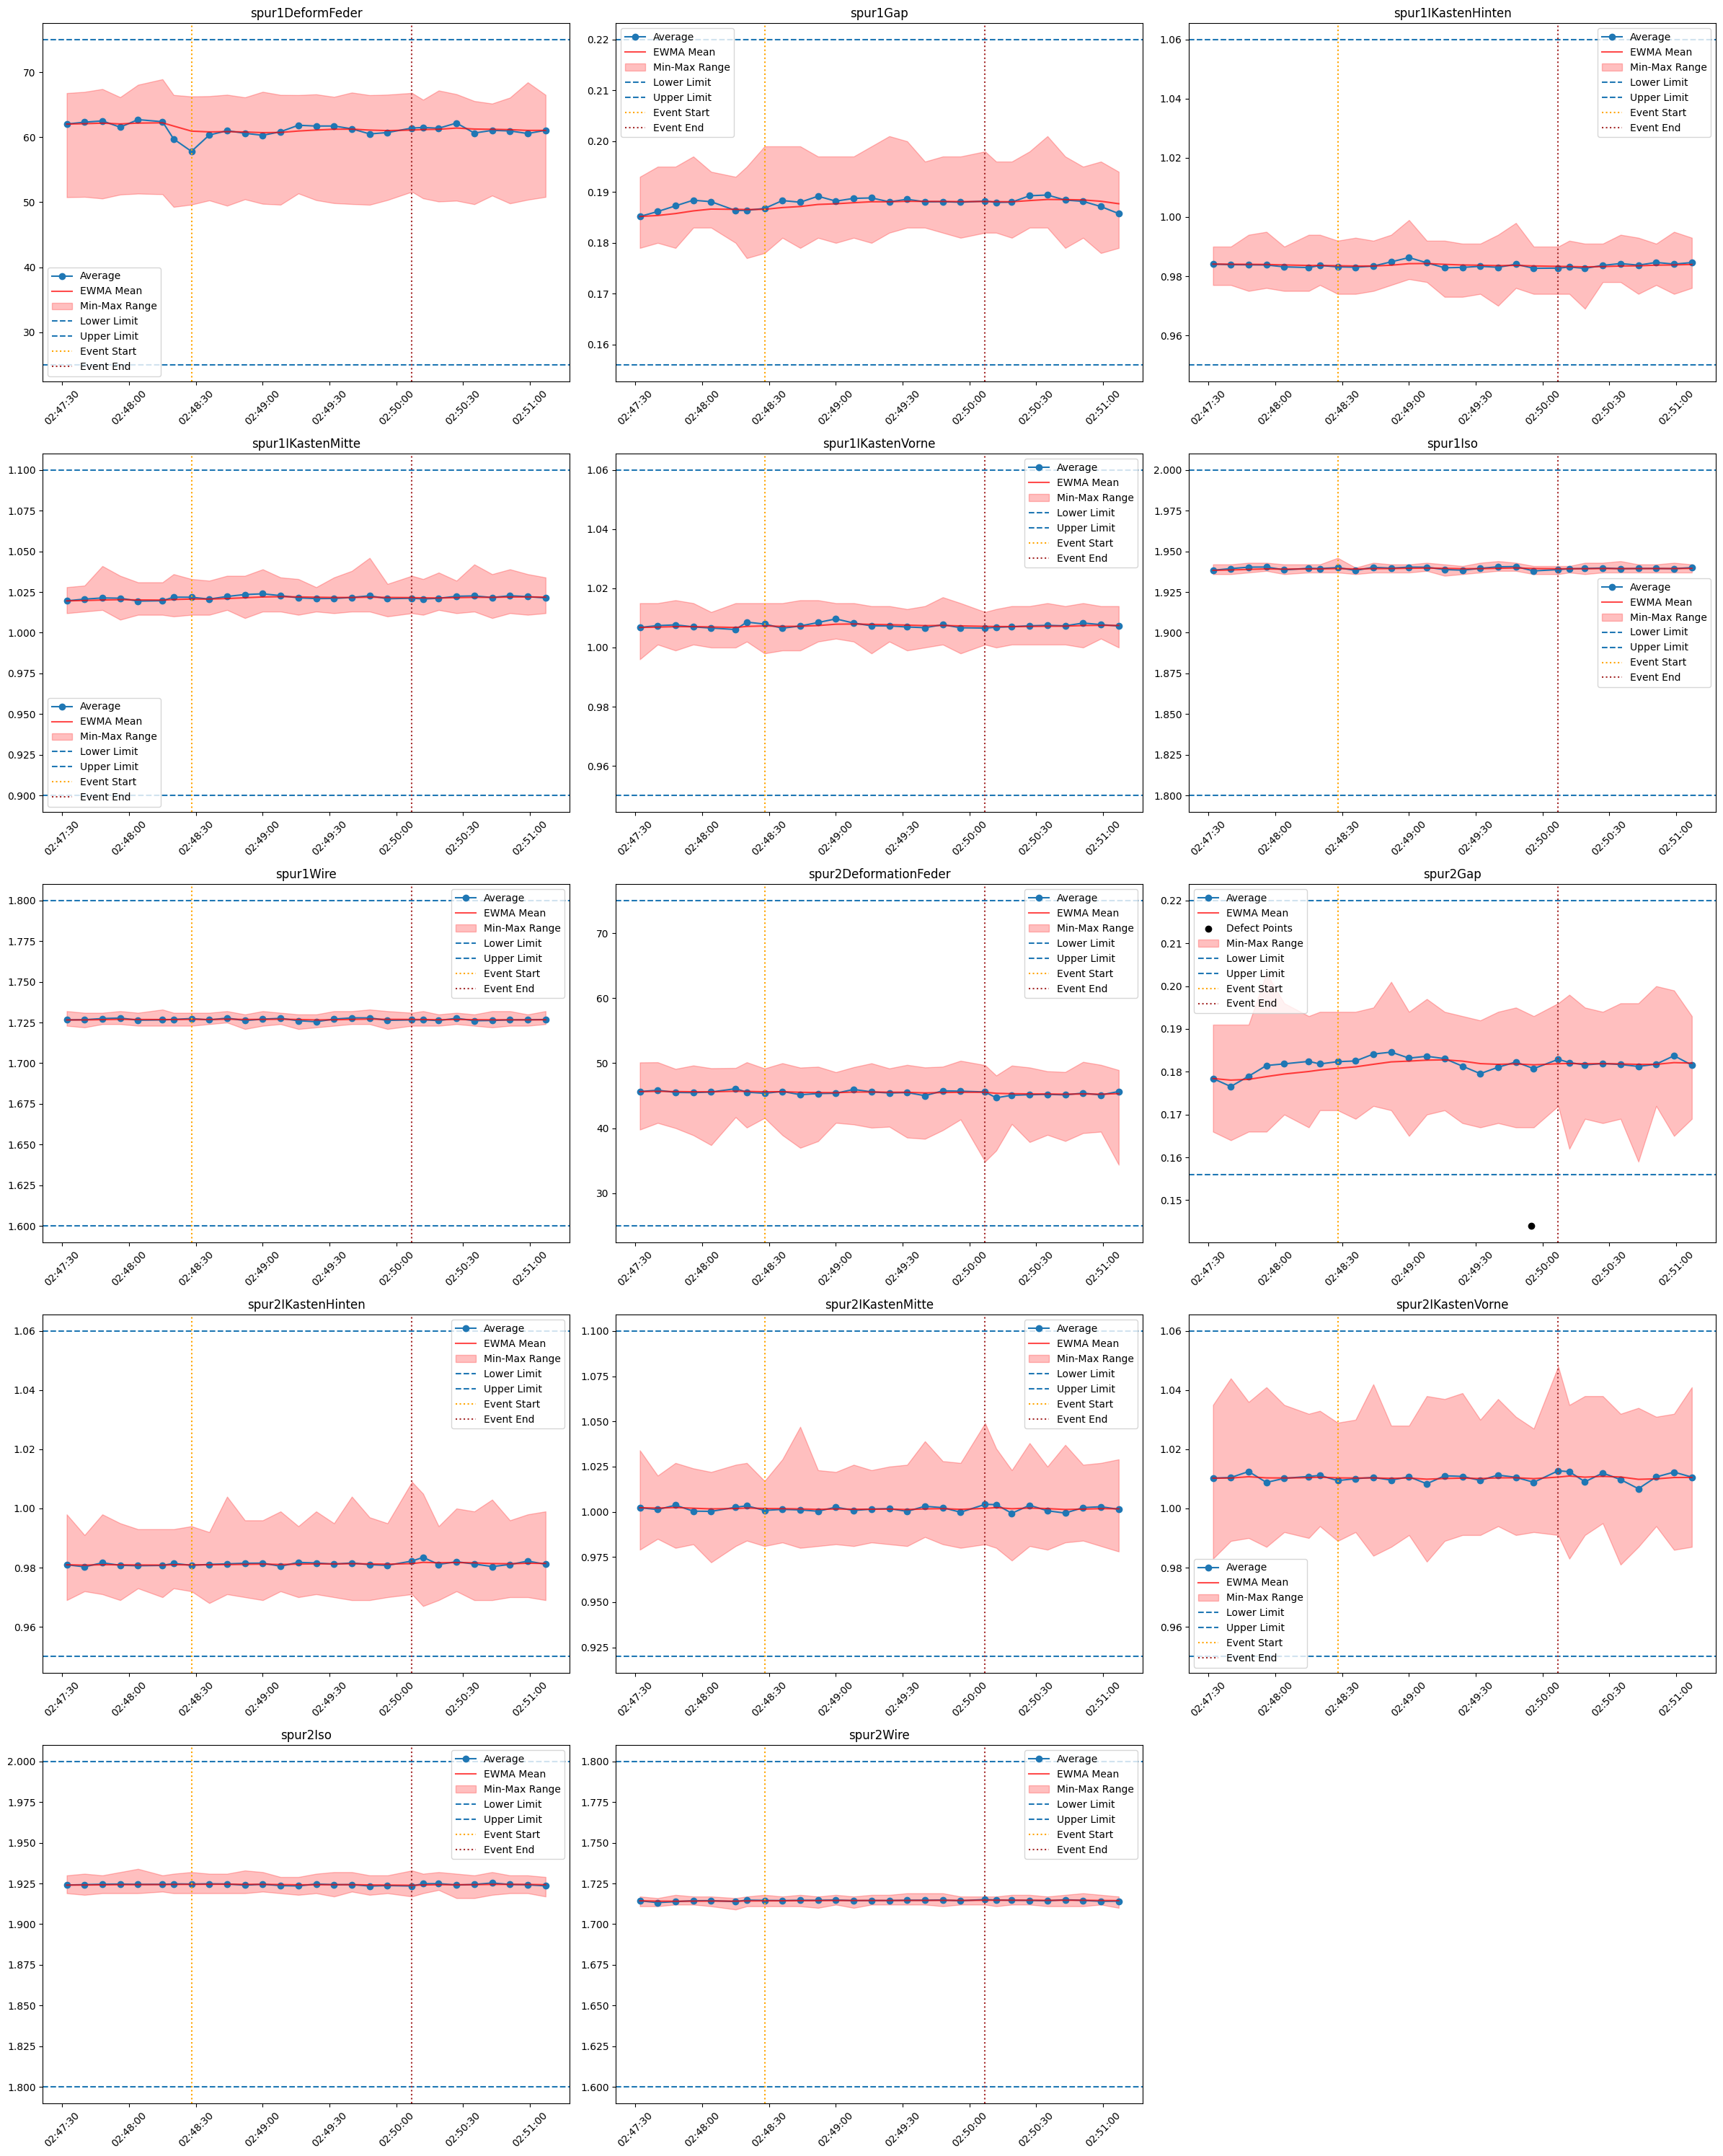

In [59]:
total_vars = sorted(small_d2.variable_name.unique().tolist())
cols = 3
rows = math.ceil(len(total_vars) / cols)

fig_width = 8 * cols  # width per column
fig_height = 6 * rows  # height per row

plt.figure(figsize=(fig_width, fig_height))

for i, var in enumerate(total_vars):
    temp = small_d2[small_d2.variable_name == var]
    temp['ewma_mean'] = temp['average'].ewm(alpha=0.2, adjust=False).mean()
    temp['ewma_std'] = temp['std'].ewm(alpha=0.2, adjust=False).mean()
    
    temp2 = small_d3[small_d3.error_variable == var]
    
    lowerLimit = temp.lowerLimit.values[0]
    upperLimit = temp.upperLimit.values[0]
    nominalValue = temp.nominalValue.values[0]
    
    time = temp.timestamp
    min_val = temp['min']
    max_val = temp['max']
    
    # Average value plotting
    plt.subplot(rows, cols, i+1)
    plt.plot(temp.timestamp, temp.average, marker = 'o', label='Average')
    plt.plot(temp.timestamp, temp.ewma_mean, label='EWMA Mean', color='red', alpha=0.7)
    
    # Defect points plotting
    if not temp2.empty:
        plt.scatter(temp2.timestamp, temp2.curr, color='black', label='Defect Points', zorder=5)
    
    
    # # Std Dev plotting
    # plt.plot(temp.timestamp, temp['std'], marker = 'o', label='Std Dev', color='green')
    # plt.plot(temp.timestamp, temp.ewma_std, label='EWMA Std', color='purple')
    
    # Min and max value area
    # plt.vlines(x=time, ymin=min_val,ymax=max_val,  linewidth=1)
    plt.fill_between(
        time,
        min_val,
        max_val,
        alpha=0.25,  # transparency
        color='red',
        label='Min-Max Range'
    )   

    # Upper and Lower Limits
    plt.axhline(lowerLimit + nominalValue, linestyle = "--", label="Lower Limit")
    plt.axhline(upperLimit + nominalValue, linestyle="--", label="Upper Limit")
    
    # Vertical lines for actual event duration
    plt.axvline(actual_start, color='orange', linestyle=':', label='Event Start')
    plt.axvline(actual_end, color='brown', linestyle=':', label='Event End')
    
    # Timestamp rotate to see it
    plt.xticks(rotation = 45)
    
    # Lables
    plt.title(f"{var}")
    plt.legend()
    # plt.ylim(nominalValue - 1.5*abs(lowerLimit), nominalValue + 1.5*abs(upperLimit))
    # others
plt.tight_layout()
plt.show()
    